# EEG - Flow

## Epochs Evokeds


Last edit: 17.04.2023 04:16
@anguyen

In [50]:
from datetime import datetime

import numpy as np
import pandas as pd
from autoreject import get_rejection_threshold
from matplotlib import pyplot as plt # viz
from scipy.stats import norm
import math

from mne import (
    Epochs, find_events, pick_types, rename_channels, write_events, read_epochs, 
    read_evokeds, read_events
)

from mne.epochs import make_metadata

from mne.viz import set_browser_backend

from eeg_flow.config import load_config
from eeg_flow.utils.bids import get_fname, get_folder
from eeg_flow.utils.concurrency import lock_files

%matplotlib qt
set_browser_backend('qt')

_, derivatives_folder_root, experimenter = load_config()

The parameters of the file to process are defined below. Locks are created to prevent someone else from running the same task and from writing the same derivatives.

In [51]:
participant = 19  # int
group       = 6  # int
task        = "oddball"  # str
run         = 2  # int

########################################################################################

derivatives_folder = get_folder(derivatives_folder_root, participant, group)
fname_stem = get_fname(participant, group, task, run)

# create locks
derivatives = [
]

locks = lock_files(*derivatives)

# load previous steps
fname_ev_standard = derivatives_folder / fname_stem / (fname_stem + "_step6_e1-standard_evoked-ave.fif")
fname_ev_target   = derivatives_folder / fname_stem / (fname_stem + "_step6_e2-target_evoked-ave.fif")
fname_ev_novel    = derivatives_folder / fname_stem / (fname_stem + "_step6_e3-novel_evoked-ave.fif")
all_evokeds = {}

all_evokeds["standard"] = read_evokeds(fname_ev_standard, condition=0)
all_evokeds["target"]   = read_evokeds(fname_ev_target,    condition=0)
all_evokeds["novel"]    = read_evokeds(fname_ev_novel,     condition=0)


Reading L:\EEG_Flow_data\derivatives\sub-P19-G6\sub-P19-G6_task-oddball_run-2\sub-P19-G6_task-oddball_run-2_step6_e1-standard_evoked-ave.fif ...
    Found the data of interest:
        t =    -200.20 ...     799.80 ms (standard)
        0 CTF compensation matrices available
        nave = 288 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.
Loaded Evoked data is baseline-corrected (baseline: [-0.200195, 0] sec)
Reading L:\EEG_Flow_data\derivatives\sub-P19-G6\sub-P19-G6_task-oddball_run-2\sub-P19-G6_task-oddball_run-2_step6_e2-target_evoked-ave.fif ...
    Found the data of interest:
        t =    -200.20 ...     799.80 ms (target)
        0 CTF compensation matrices available
        nave = 34 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.
Loaded Evoked data is baseline-corrected (baseline: [-0.200195, 0] sec)
Reading L:\EEG_Flow_data\derivatives\sub-P19-G6\sub-P19-G6_task-odd

## 7.1 

In [52]:
# fname_metadata = derivatives_folder / fname_stem / (fname_stem + "_step6_a-metadata.csv")
# metadata = pd.read_csv(fname_metadata)

In [53]:
event_id = dict(standard=1, target=2, novel=3)

In [65]:
max_peak = False
min_peak = False

for event in event_id:
    all_evokeds[event].drop_channels(all_evokeds[event].info['bads']) #remove bads from this report)
    event_max = np.amax(all_evokeds[event].data)
    event_min = np.amin(all_evokeds[event].data)

    if max_peak == False or max_peak < event_max:
        max_peak = event_max
    if min_peak == False or min_peak > event_min:
        min_peak = event_min

min_peak *=10**6
max_peak *=10**6

print(min_peak, max_peak)

ylim_values = {}

for event in event_id:
    event_max = np.amax(all_evokeds[event].data)
    event_min = np.amin(all_evokeds[event].data)
    ylim_values[event] = [event_max * 1.2 * 10**6, event_min * 1.2 * 10**6]
ylim_values


-10.829636266862508 14.677049875899684


{'standard': [4.940674079989549, -9.67255255091004],
 'target': [13.397853399510495, -12.99556352023501],
 'novel': [17.61245985107962, -11.799129788414575]}

In [7]:
## use this if limits need to be set manually
max_peak, min_peak = 13, -10

f, ax = plt.subplots(3, 1, figsize=(8, 8))
f.suptitle(fname_stem + " | All evoked | All channels | Fixed scale | (" + str(min_peak) +", "+str(max_peak)+")")

ylim = dict(eeg=[max_peak * 1.2, min_peak * 1.2])

for k, (condition, evo) in enumerate(all_evokeds.items()):
    print(k, condition, evo)
    evo.plot(axes=ax[k], ylim = ylim, zorder="std")
    ax[k].set_title(condition.capitalize())
f.tight_layout()

timestampStr = datetime.now().strftime("%Y_%m_%d_%H_%M")
fname_bridge_plot = derivatives_folder / fname_stem / "plots" / (fname_stem + "_step7_allElec_fixedScale-"+timestampStr+".svg")
f.savefig(fname_bridge_plot)

# fig_all_evoked_fixed = f
# fig_all_evoked_fixed

0 standard <Evoked | 'standard' (average, N=288), -0.2002 – 0.7998 sec, baseline -0.200195 – 0 sec, 64 ch, ~607 kB>
1 target <Evoked | 'target' (average, N=34), -0.2002 – 0.7998 sec, baseline -0.200195 – 0 sec, 64 ch, ~607 kB>
2 novel <Evoked | 'novel' (average, N=36), -0.2002 – 0.7998 sec, baseline -0.200195 – 0 sec, 64 ch, ~607 kB>


C:\Users\anguyen\AppData\Local\Temp\ipykernel_12544\555241769.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


In [ ]:
# ## this is for a zoomed in view for each plot
# ##this would have been nice but we need the y axis to be swapped.
# ## until there's a clean way to do it, use the next cell instead

# f, ax = plt.subplots(3, 1, figsize=(8, 8))
# f.suptitle(fname_stem + " | All evoked | All channels | Adaptive scale | (" + str(min_peak) +", "+str(max_peak)+")")

# for k, (condition, evo) in enumerate(all_evokeds.items()):
#     print(k, condition, evo)
#     evo.plot(axes=ax[k])
#     ax[k].set_title(condition.capitalize())
# f.tight_layout()

# timestampStr = datetime.now().strftime("%Y_%m_%d_%H_%M")
# # fname_bridge_plot = derivatives_folder / fname_stem / "plots" / (fname_stem + "_step7_allElec_AdaptiveScale-"+timestampStr+".svg")
# # f.savefig(fname_bridge_plot)

# fig_all_evoked_fixed = f
# fig_all_evoked_fixed

C:\Users\anguyen\AppData\Local\Temp\ipykernel_12544\2442878465.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


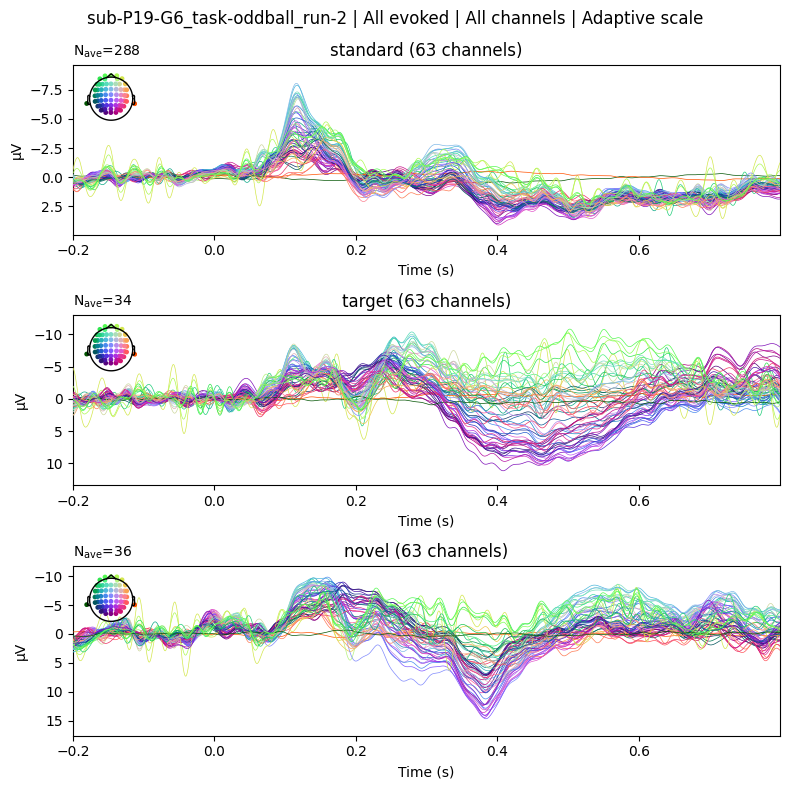

In [67]:
fig = plt.figure(figsize=(8, 8))

ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)

fig.suptitle(fname_stem + " | All evoked | All channels | Adaptive scale")

ylim_standard = dict(eeg=ylim_values["standard"])
ylim_target = dict(eeg=ylim_values["target"])
ylim_novel = dict(eeg=ylim_values["novel"])

all_evokeds["standard"].plot(picks='eeg', axes=ax1, spatial_colors=True, zorder="std", ylim = ylim_standard, titles="standard")
all_evokeds["target"].plot(  picks='eeg', axes=ax2, spatial_colors=True, zorder="std", ylim = ylim_target, titles="target")
all_evokeds["novel"].plot(   picks='eeg', axes=ax3, spatial_colors=True, zorder="std", ylim = ylim_novel, titles="novel")
fig.tight_layout()

timestampStr = datetime.now().strftime("%Y_%m_%d_%H_%M")
fname_bridge_plot = derivatives_folder / fname_stem / "plots" / (fname_stem + "_step7_allElec_AdaptiveScale-"+timestampStr+".svg")
fig.savefig(fname_bridge_plot)
fig

## 6.2 Epochs


## 6.3 Save the rest of the derivatives

The ICA decomposition can be saved.

In [ ]:
# fname_ev_standard = derivatives_folder / fname_stem / (fname_stem + "_step6_e1-standard_evoked-ave.fif")
# fname_ev_novel    = derivatives_folder / fname_stem / (fname_stem + "_step6_e2-novel_evoked-ave.fif")
# fname_ev_target   = derivatives_folder / fname_stem / (fname_stem + "_step6_e3-target_evoked-ave.fif")

# all_evokeds["standard"].save(fname_ev_standard)
# all_evokeds["novel"].save(fname_ev_novel)
# all_evokeds["target"].save(fname_ev_target)

Regardless of the success of the task, the locks must be released.
If this step is forgotten, someone might have to remove the corresponding `.lock` file manually.

In [68]:
for lock in locks:
    lock.release()
del locks  # delete would release anyway